In [1]:
# First of all, some general python and eWaterCycle libraries need to be imported:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
#import seaborn as sns
#sns.set()

#needed
from ipywidgets import IntProgress
from IPython.display import display

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [2]:
# As stated in chapter 3, eWaterCycle provides access to the Caravan dataset, from which a Camel dataset of the catchment of the Wien River is loaded.
camelsgb_id = "lamah_208082"

In [3]:
# calibration dates op 75% van de experiment dates zetten!!!

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2018-01-01T00:00:00Z"

calibration_start_time = experiment_start_date
calibration_end_time = "2007-08-31T00:00:00Z"

validation_start_time = "2007-09-01T00:00:00Z" 
validation_end_time = experiment_end_date

In [4]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [5]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camelsgb_id,
# )


# option two or three: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(forcing_path_caravan)

print(camelsgb_forcing)

CaravanForcing(
    start_time='1981-08-01T00:00:00Z',
    end_time='2018-01-01T00:00:00Z',
    directory=PosixPath('/home/rhut/forcing/lamah_208082/caravan'),
    shape=PosixPath('/home/rhut/forcing/lamah_208082/caravan/lamah_208082.shp'),
    filenames={
        'tas': 'lamah_208082_1981-08-01_2018-01-01_tas.nc',
        'pr': 'lamah_208082_1981-08-01_2018-01-01_pr.nc',
        'tasmax': 'lamah_208082_1981-08-01_2018-01-01_tasmax.nc',
        'evspsblpot': 'lamah_208082_1981-08-01_2018-01-01_evspsblpot.nc',
        'tasmin': 'lamah_208082_1981-08-01_2018-01-01_tasmin.nc',
        'Q': 'lamah_208082_1981-08-01_2018-01-01_Q.nc'
    }
)

Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below, and is plotted.

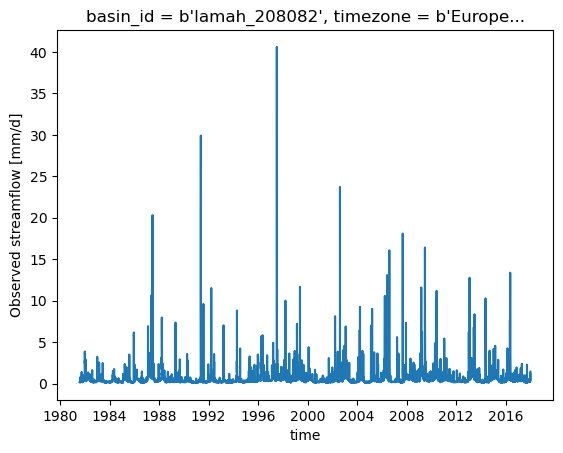

In [6]:
#quick plot of the discharge data.
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])
ds_forcing["Q"].plot()

## Calibration

The HBV model contains five stores where the water is stored and nine parameters that control the flow between those stores and in and out of the model. For the storages an array of starting values is specified. The values for the parameters will later be estimated using optimization.

In [7]:
N = 500

In [8]:

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]\

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,  .01])
# p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,  0.5])

p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   0.1,  .01,  .0001,  .01])
p_max_initial = np.array([8,    4,  800,   4,    3,     10,    3,   .1,  5])

#create empty array to fill 
parameters = np.zeros([len(p_min_initial), N])

#fill with random values bounded by the min and max given above.
for param in range(len(p_min_initial)):
    parameters[param,:] = np.random.uniform(p_min_initial[param],p_max_initial[param],N)


In [9]:

ensemble = []
for counter in range(N): 
    ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
    config_file, _ = ensemble[counter].setup(
                            parameters = parameters[:,counter],
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
                               )
    ensemble[counter].initialize(config_file)

In [10]:
def calibrationObjective(modelOutput,observation,start_calibration,end_calibration):
    # a function that takes in two dataFrames, interpolates the model output to the
    # observations and calculates the average absolute difference between the two.

    #combine the two in one dataFrame
    #hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1, keys = ['model', 'obs'])
    hydro_data = pd.concat([modelOutput, observation], axis=1, keys = ['model', 'obs'])

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate mean absolute difference

    diff = hydro_data['model'] - hydro_data['obs']
    rms = np.sqrt(np.mean(diff**2))

    return rms

In [11]:
def objective_function_sorted_maximum(model_output, observation, calibration_start_time, calibration_end_time):
    calibration_start_time = pd.to_datetime(calibration_start_time)
    calibration_end_time = pd.to_datetime(calibration_end_time)

    model_output.index = model_output.index.tz_localize(None)  # Remove timezone
    observation.index = observation.index.tz_localize(None)
    calibration_start_time = calibration_start_time.tz_localize(None)
    calibration_end_time = calibration_end_time.tz_localize(None)

    model_output_filtered = model_output.loc[calibration_start_time:calibration_end_time]
    obs_filtered = observation.loc[calibration_start_time:calibration_end_time]
    
    # Sort data from high to low
    sorted_model_data = np.sort(model_output_filtered)[::-1]  # Sorteer aflopend
    sorted_obs_data = np.sort(obs_filtered)[::-1]
    
    #calculate return periods
    m = len(sorted_model_data)
    rank = np.arange(1, m + 1)
    return_periods_days_model = (m + 1) / rank
    return_periods_years_model = return_periods_days_model / 365.25
    
    
    m = len(sorted_obs_data)
    rank = np.arange(1, m + 1)
    return_periods_days_obs = (m + 1) / rank
    return_periods_years_obs = return_periods_days_obs / 365.25

    sorted_model_data_subset = sorted_model_data[return_periods_years_model >= 0.5]
    sorted_obs_data_subset = sorted_obs_data[return_periods_years_obs >= 0.5]

    if len(sorted_model_data_subset) is not len (sorted_obs_data_subset):
        raise ValueError("observation and data not equal length")

    objective_this_model = np.sqrt(np.mean((sorted_model_data_subset - sorted_obs_data_subset)**2))

    return objective_this_model

In [12]:
#an object to show a progress bar, since this can take a while:
f = IntProgress(min=0, max=N) # instantiate the bar
display(f) # display the bar

#converting the observations to a pandas object
obs_all_dataframe = ds_forcing.to_dataframe() 
obs_series = obs_all_dataframe["Q"]
#an empty array to store the results in
objectives = []

#loop over all ensemble members
for ensembleMember in ensemble:
    Q_m = []
    time = []
    while ensembleMember.time < ensembleMember.end_time:
        ensembleMember.update()
        discharge_this_timestep = ensembleMember.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))

    #calculate the objective function 
    discharge_series = pd.Series(data=Q_m, name="Modelled_discharge", index=time)
    
    objective_this_model = objective_function_sorted_maximum(discharge_series,obs_series, calibration_start_time, calibration_end_time)
    objectives.append(objective_this_model)

    #it is good practice to remove any variable you don't need anymore to save memory.
    del Q_m, time, discharge_series, objective_this_model
   
    #update progress bar
    f.value += 1

# print(objectives)  

IntProgress(value=0, max=500)

In [13]:
#let's also show the minimal values:
parameters_minimum_index = np.argmin(np.array(objectives))

objective_minimum = np.min(objectives)

parameters_minimum = parameters[:,parameters_minimum_index]

print("Best parameter index:", parameters_minimum_index)
print("Best parameter set:", parameters_minimum)
print("Objective: ", objective_minimum)


Best parameter index: 308

Best parameter set: [1.77630846e+00 2.02376467e-01 8.50402672e+01 1.37646823e+00
 2.35618204e+00 1.06546938e+00 2.85274489e+00 4.94525135e-02
 1.56810273e+00]

Objective:  2.437360832592572

In [14]:
#finaly, just like before, we remove the models themselves to save up space and memory.
for ensembleMember in ensemble:
    ensembleMember.finalize()

In [15]:
par = [7.085, 0.837, 76.373, 1.112, 0.245,7.801,0.096,0.003,0.226]

In [16]:

model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=parameters_minimum, initial_storage=s_0)
model.initialize(config_file)

In [17]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [18]:
discharge_dataseries = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0.5, 1.0, 'Modelled and Observed discharge')

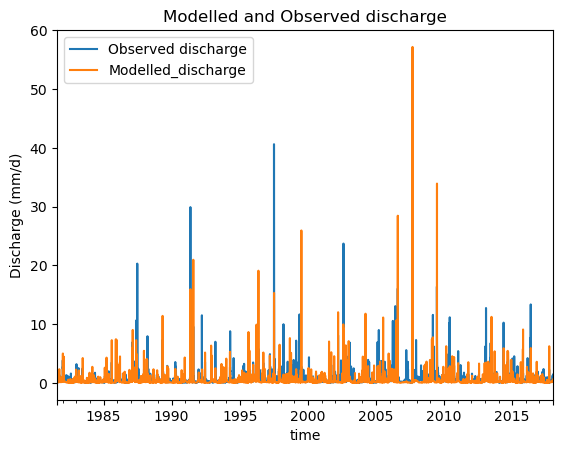

In [19]:
obs_series.plot(label="Observed discharge")
discharge_dataseries.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")
plt.title('Modelled and Observed discharge')

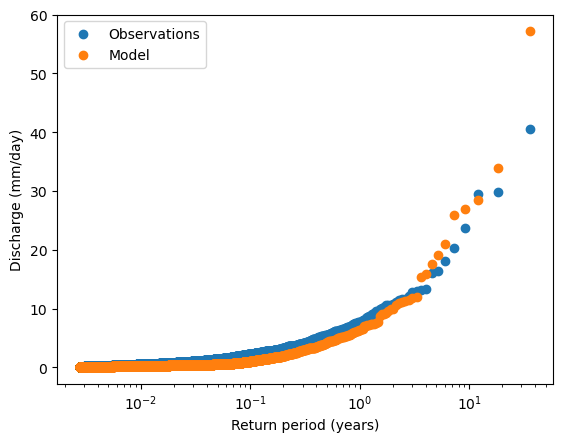

In [21]:
# Sort data from high to low
sorted_model_data = np.sort(discharge_dataseries)[::-1]  # Sorteer aflopend
ds_forcing_filtered = np.sort(obs_series)[::-1]

#calculate return periods
m = len(sorted_model_data)
rank = np.arange(1, m + 1)
return_periods_days_model = (m + 1) / rank
return_periods_years_model = return_periods_days_model / 365.25


m = len(ds_forcing_filtered)
rank = np.arange(1, m + 1)
return_periods_days_obs = (m + 1) / rank
return_periods_years_obs = return_periods_days_obs / 365.25

plt.xscale('log')
plt.scatter(return_periods_years_obs, ds_forcing_filtered, label='Observations')
plt.scatter(return_periods_years_model, sorted_model_data, label='Model')
plt.legend()
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (mm/day)')
plt.savefig('return period calibration.png')